Using the House Prices dataset from kaggle your task will be to predict the prices of the houses. 

* load dataset from Thinkful PostgreSQL database
* investigate the data, and do any necessary data cleaning.
* explore the data and find some variables that you think would be useful in predicting house prices. 
* Build your initial model using these features and estimate the parameters using OLS. 

In [78]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
import statsmodels.api as sm

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'
                       .format(postgres_user, postgres_pw, postgres_host,
                              postgres_port, postgres_db))

df = pd.read_sql_query('SELECT * FROM houseprices', con=engine)

engine.dispose()

In [3]:
df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

In [5]:
#one hot encoding categorical variables and creating correlation matrix
one_hot = pd.get_dummies(df, drop_first=True)
corr_df_0 = one_hot.corr()

#examining the variables most correlated with target variable saleprice
corr_df_0['saleprice'].sort_values(ascending=False)

saleprice           1.000000
overallqual         0.790982
grlivarea           0.708624
garagecars          0.640409
garagearea          0.623431
                      ...   
masvnrtype_None    -0.374468
garagefinish_Unf   -0.410608
bsmtqual_TA        -0.452394
kitchenqual_TA     -0.519298
exterqual_TA       -0.589044
Name: saleprice, Length: 247, dtype: float64

In [6]:
#examining the variables most correlated with saleprice
#abosolute values reported here to help rank the magnitude of each correlation 
abs(corr_df_0['saleprice']).sort_values(ascending=False)

saleprice            1.000000
overallqual          0.790982
grlivarea            0.708624
garagecars           0.640409
garagearea           0.623431
                       ...   
foundation_Wood      0.002711
garagecond_Gd        0.000983
roofstyle_Mansard    0.000308
roofmatl_Metal       0.000304
bsmtfintype2_GLQ     0.000076
Name: saleprice, Length: 247, dtype: float64

In [7]:
#finding and dropping values that have less than 5% correlation in either direction with our target variable to shrink feature space
low_corr = corr_df_0.loc[abs(corr_df_0['saleprice']) < .05]
low_corr = low_corr['saleprice'].index
low_corr_list = [x for x in low_corr]

df_pca = one_hot.drop(low_corr_list, axis=1)

c:\python\python37\lib\site-packages\numpy\lib\histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
c:\python\python37\lib\site-packages\numpy\lib\histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


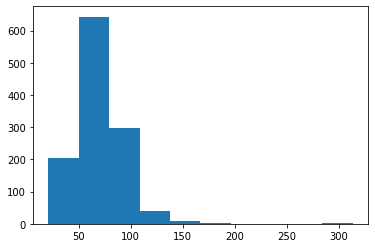

In [8]:
#examining distribution of lotfrantage variable
plt.hist(df_pca['lotfrontage'])
plt.show()

In [9]:
df_pca['lotfrontage'].fillna(df_pca['lotfrontage'].mean(), inplace=True)

In [10]:
#checking correlation between garageyrblt and yearbuild
corr_df_0['garageyrblt'].sort_values(ascending=False)

garageyrblt            1.000000
yearbuilt              0.825667
foundation_PConc       0.661998
yearremodadd           0.642277
garagecars             0.588920
                         ...   
garagefinish_Unf      -0.542316
exterqual_TA          -0.596502
bsmtqual_TA           -0.600124
exterior1st_AsphShn         NaN
extercond_Po                NaN
Name: garageyrblt, Length: 247, dtype: float64

In [11]:
#filling remaining missing values
df_pca['garageyrblt'].fillna(df_pca['yearbuilt'], inplace=True)
df_pca['masvnrarea'].fillna(df_pca['masvnrarea'].mean(), inplace=True)

In [12]:
#checking for any overlooked missing values
df_pca.isnull().sum().sort_values(ascending=False)


salecondition_Partial    0
neighborhood_Mitchel     0
neighborhood_Somerst     0
neighborhood_Sawyer      0
neighborhood_SWISU       0
                        ..
bsmtcond_Gd              0
bsmtqual_TA              0
bsmtqual_Gd              0
bsmtqual_Fa              0
mssubclass               0
Length: 153, dtype: int64

In [13]:
df_pca.dropna(inplace=True)

scaled_df = StandardScaler().fit_transform(df_pca)

sklearn_pca = PCA(n_components=5)

pca_arrays  = sklearn_pca.fit_transform(scaled_df)

ratio = sklearn_pca.explained_variance_ratio_
print(ratio)
print(ratio.sum())

[0.10923791 0.04390671 0.03471298 0.03114326 0.024     ]
0.24300086242313862


In [14]:
df_pca['pca_1'] = pca_arrays[:,0]
df_pca['pca_2'] = pca_arrays[:,1]
df_pca['pca_3'] = pca_arrays[:,2]
df_pca['pca_4'] = pca_arrays[:,3]
df_pca['pca_5'] = pca_arrays[:,4]

In [15]:
corr_df = df_pca.corr()
abs(corr_df['saleprice']).sort_values(ascending=False)

saleprice                1.000000
pca_1                    0.807859
overallqual              0.790982
grlivarea                0.708624
garagecars               0.640409
                           ...   
exterior1st_WdShing      0.051317
exterior1st_BrkComm      0.051264
fence_MnWw               0.051164
salecondition_AdjLand    0.050686
extercond_Gd             0.050467
Name: saleprice, Length: 158, dtype: float64

In [19]:
corr_df.shape

(158, 158)

In [32]:
low_corr_2 = corr_df.loc[abs(corr_df['saleprice']) < .30]
low_corr_2 = low_corr_2['saleprice'].index
low_corr_list_2 = [x for x in low_corr_2]

pca_corr_df = df_pca.drop(low_corr_list_2, axis=1)
pca_corr = pca_corr_df.corr()
pca_corr.shape

(43, 43)

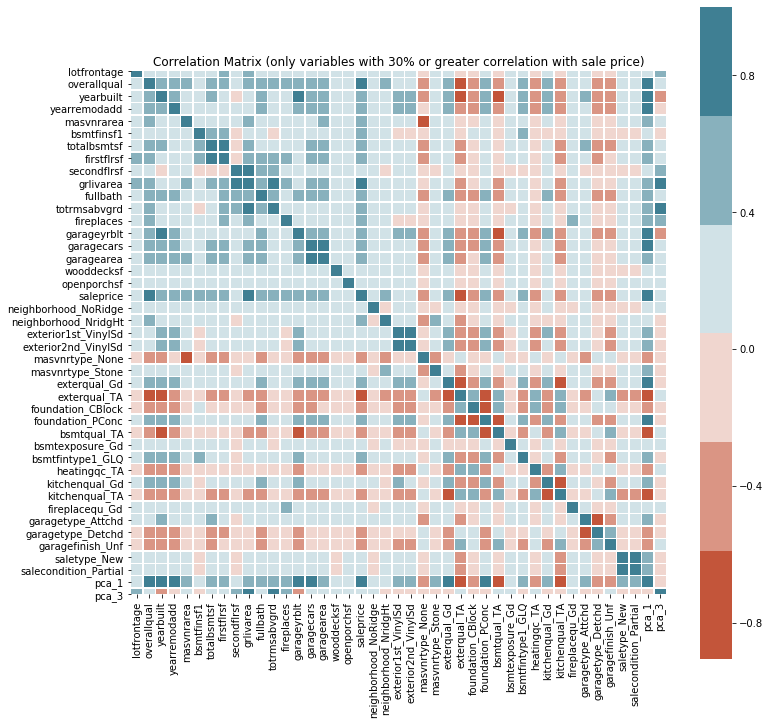

In [31]:
fig = plt.figure(figsize=(12,12))
ax = sns.heatmap(
    pca_corr, 
    cmap=sns.diverging_palette(20, 220), 
    square=True,
    linewidths=.5).set_title('Correlation Matrix (only variables with 30% or greater correlation with sale price)')

In [39]:
x_coord = df_pca['pca_1']
y_coord = df_pca['saleprice']

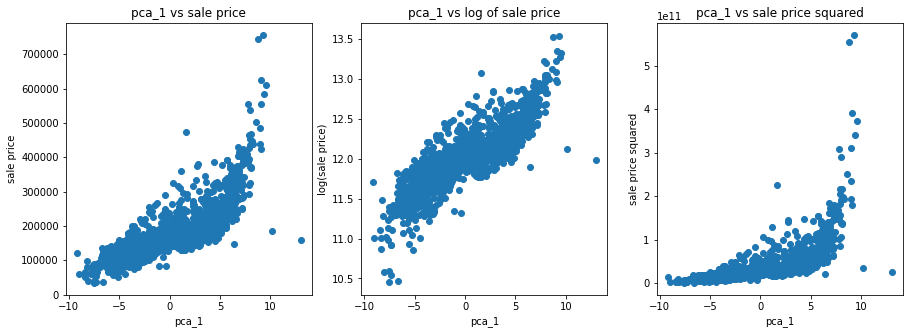

In [72]:
fig = plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.scatter(x_coord, y_coord)
plt.title('pca_1 vs sale price')
plt.xlabel('pca_1')
plt.ylabel('sale price')

plt.subplot(1,3,2)
plt.scatter(x_coord, np.log(y_coord))
plt.title('pca_1 vs log of sale price')
plt.xlabel('pca_1')
plt.ylabel('log(sale price)')

plt.subplot(1,3,3)
plt.scatter(x_coord, y_coord**2)
plt.title('pca_1 vs sale price squared')
plt.xlabel('pca_1')
plt.ylabel('sale price squared')
plt.show()

In [73]:
x_coord = df_pca['overallqual']
y_coord = df_pca['saleprice']

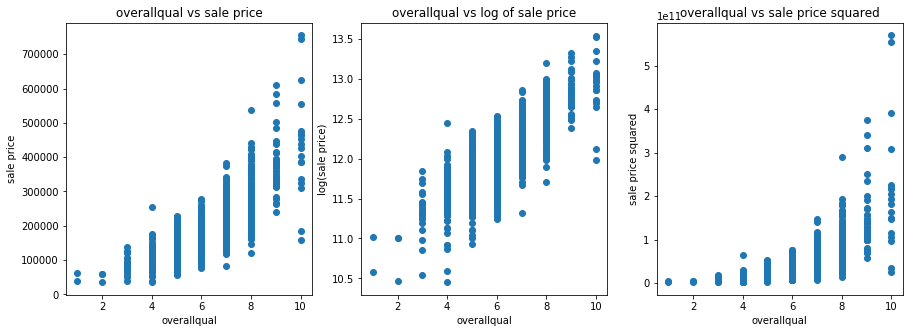

In [75]:
fig = plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.scatter(x_coord, y_coord)
plt.title('overallqual vs sale price')
plt.xlabel('overallqual')
plt.ylabel('sale price')

plt.subplot(1,3,2)
plt.scatter(x_coord, np.log(y_coord))
plt.title('overallqual vs log of sale price')
plt.xlabel('overallqual')
plt.ylabel('log(sale price)')

plt.subplot(1,3,3)
plt.scatter(x_coord, y_coord**2)
plt.title('overallqual vs sale price squared')
plt.xlabel('overallqual')
plt.ylabel('sale price squared')
plt.show()

In [79]:
#preparing our matricies for determination of linear 
Y = df_pca['saleprice']
X = df_pca[['pca_1','overallqual']]

#manually adding constant 
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()


c:\python\python37\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     1758.
Date:                Sun, 29 Sep 2019   Prob (F-statistic):               0.00
Time:                        17:01:53   Log-Likelihood:                -17648.
No. Observations:                1460   AIC:                         3.530e+04
Df Residuals:                    1457   BIC:                         3.532e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4.171e+04   8543.861      4.882      0.000     2.5e+04    5.85e+04
pca_1        9442.4012    469.577     20.108      0.000    8521.282    1.04e+04
overallqual  2.282e+04   1388.567     16.437      0.000    2.01e+04    2.55e+04
==============================================================================
Omnibus:                      781.393   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14066.676
Skew:                           2.080   Prob(JB):                         0.00
Kurtosis:                      17.626   Cond. No.                         49.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""